In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression as linreg
from sklearn.model_selection import cross_validate, KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import factor_analyzer as fa
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import gspread as gs
import gspread_dataframe as gd
import copy
import itertools



%matplotlib inline
plt.style.use('fivethirtyeight')

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,start,end,duration_in_sec,recorded,tss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,2022-02-17 07:41:22,2022-02-17 07:58:46,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,2022-02-17 07:52:11,2022-02-17 08:01:19,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,2022-02-17 07:55:22,2022-02-17 08:03:16,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN


In [56]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]

In [57]:
# Check missing data patterns
missing = tss_df[item_labels_li].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending=False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending=False).head(5))

# in this case it is straightforward - just drop the 2 rows with missing data
tss_df.dropna(subset=item_labels_li, inplace=True)

# if missing data should be more common with small amounts of missing data per case, might need different approach obv

Top 5 cols with missing data per col:
tss_coh_1     2
tss_rep_9     2
tss_cre_8     2
tss_cre_10    2
tss_qua_2     2
dtype: int64

Top 5 missing data per row:
117    72
77     35
0       0
159     0
148     0
dtype: int64


In [58]:
# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations as I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     51.753425
std       9.827372
min      32.000000
25%      44.000000
50%      52.000000
75%      60.000000
max      70.000000
dtype: float64


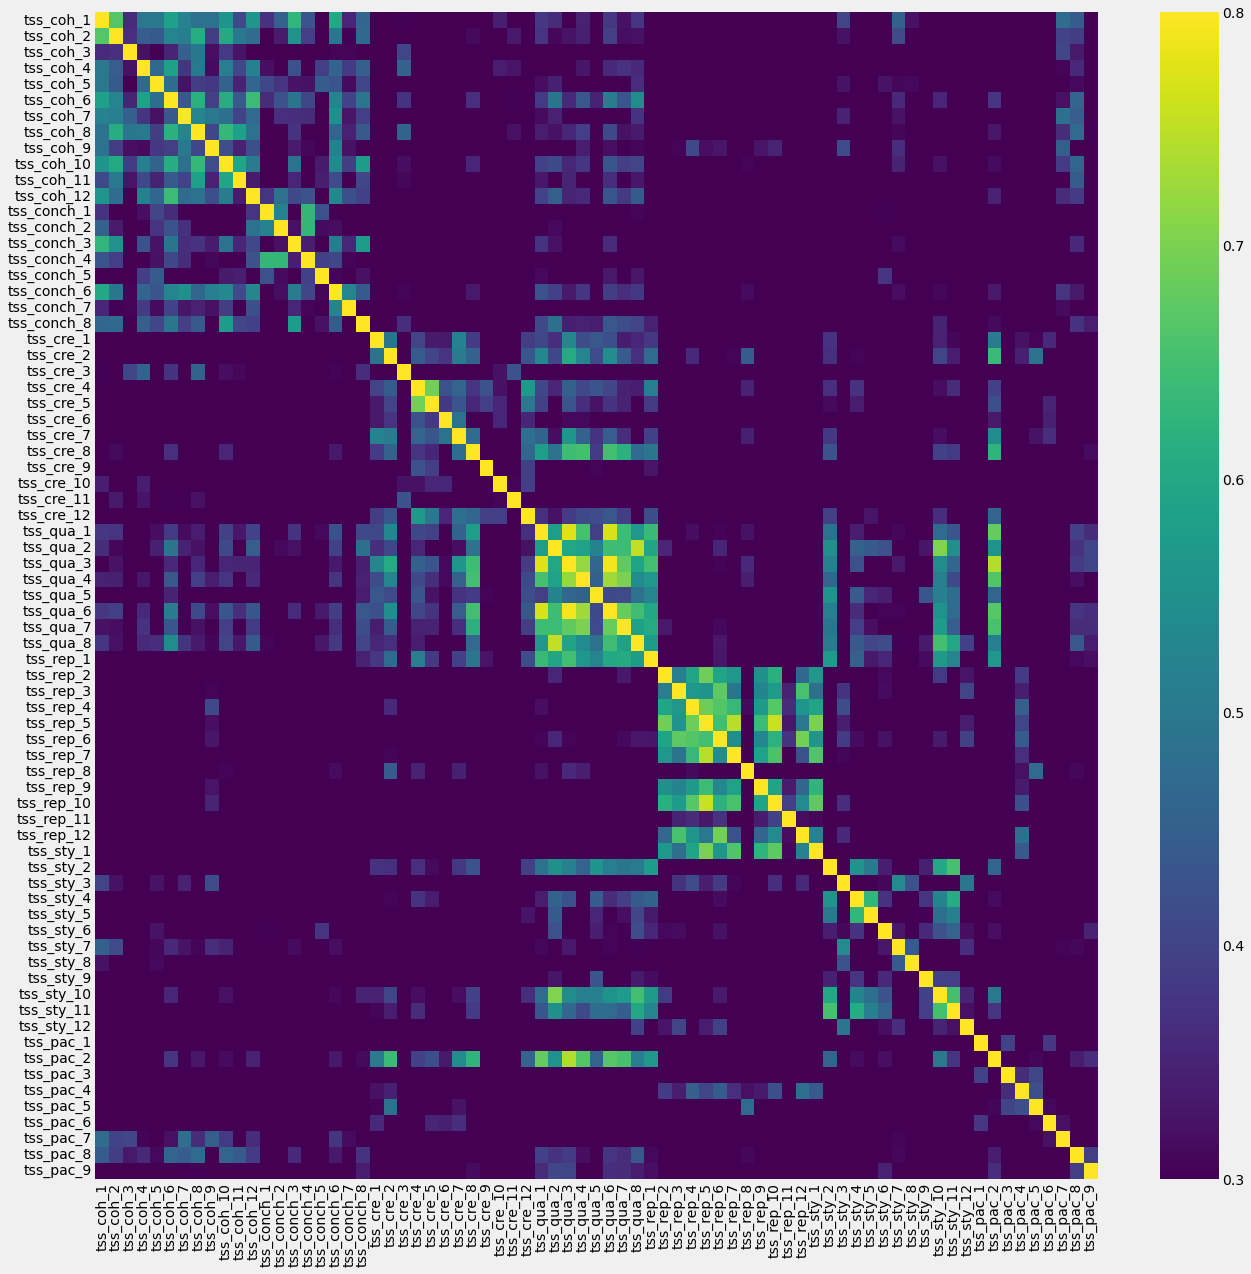

In [59]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [60]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_rep_8", "tss_rep_10",
    "tss_sty_8", "tss_sty_9", "tss_sty_12"
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6", "tss_pac_9"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

tss_rep_8: The plot had no development.
Correlations >= .3:
tss_conch_6    0.315107
tss_cre_2      0.441634
tss_rep_4      0.312424
tss_pac_4      0.321328
tss_pac_5      0.473190

tss_rep_10: Characters said or did the same thing many times over.
Correlations >= .3:
tss_coh_9     0.348984
tss_rep_3     0.572863
tss_rep_4     0.668599
tss_rep_5     0.760880
tss_rep_6     0.621286
tss_rep_7     0.656667
tss_rep_9     0.592724
tss_rep_11    0.395360
tss_rep_12    0.537945
tss_sty_1     0.676303
tss_sty_3     0.366259
tss_pac_4     0.419847

tss_sty_8: The writing style was too complicated to be understood easily.
Correlations >= .3:
tss_coh_1    0.322945
tss_sty_3    0.425810
tss_sty_5    0.300371

tss_sty_9: The story contained a great deal of detail.
Correlations >= .3:
tss_qua_2     0.327961
tss_qua_5     0.429934
tss_qua_8     0.335116
tss_rep_1     0.314958
tss_sty_2     0.344815
tss_sty_4     0.376746
tss_sty_5     0.302273
tss_sty_6     0.356286
tss_sty_10    0.393822
tss_sty_11  

In [61]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)

# excluded_items_li = [
#     "tss_sty_8"
# ]

# for item in excluded_items_li:
#     items_analysis_li.remove(item)

In [62]:
# Check for multicollinearity
def reduce_multicoll(df, vars_li, vars_descr=[], print_details=True):
    reduced_vars = copy.deepcopy(vars_li)
    print("Beginning check for multicollinearity")
    vars_corr = df[reduced_vars].corr()
    det = np.linalg.det(vars_corr)
    print("\nDeterminant of initial correlation matrix: {}\n".format(det))

    if det > .00001:
        print("Determinant is > .00001. No issues with multicollinearity detected.")
        return(reduced_vars)

    print("Starting to remove redundant variables by acessing mutlicollinearity with VIF...\n")
    count_missing = len(df) - len(df.dropna(subset=vars_li))
    if count_missing > 0:
        print("This requries dropping missing values.",
              "The following procedure will ignore {} cases with missing values".format(count_missing))
    while det <= .00001:
        # could implement pairwise dropping of missing here at some point
        # but until you have a case with lots of missing data, this will work fine
        x_df = df.dropna(subset=vars_li)[reduced_vars]
        vifs = [vif(x_df.values, i)
                for i in range(len(x_df.columns))]
        vif_data = pd.Series(vifs, index=x_df.columns)
        vif_max = (vif_data.idxmax(), vif_data.max())

        if print_details:
            print("Excluded item {}. VIF: {:.2f}".format(
                vif_max[0], vif_max[1]))

            if len(vars_descr) > 0:
                print("('{}')".format(vars_descr[vif_max[0]]))
            print("")

        reduced_vars.remove(vif_max[0])

        vars_corr = df[reduced_vars].corr()
        det = np.linalg.det(vars_corr)

    print("Done! Determinant is now: {:.6f}".format(det))
    count_removed = len(vars_li) - len(reduced_vars)
    print("I have excluded {} redunant items with {} items remaining".format(
        count_removed, len(reduced_vars)))

    return(reduced_vars)

In [63]:
items_analysis_li = reduce_multicoll(
    tss_df, items_analysis_li, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 6.3481982191523685e-25

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_qua_3. VIF: 51.86
('The story was fun to read.')

Excluded item tss_coh_12. VIF: 35.64
('The story lacked logic.')

Excluded item tss_coh_1. VIF: 34.82
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_cre_4. VIF: 31.91
('The story was creative.')

Excluded item tss_qua_6. VIF: 30.06
('I liked this story.')

Excluded item tss_cre_2. VIF: 28.64
('The story was boring.')

Excluded item tss_rep_5. VIF: 27.50
('In the story, the same things happened again and again.')

Excluded item tss_conch_5. VIF: 26.67
('The descriptions of characters in the story were plausible.')

Excluded item tss_rep_4. VIF: 26.01
('The story was very repetitive.')

Excluded item tss_rep_12. VIF: 25.43
('Particular words were used too often in the story.')

Excluded item tss

In [64]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=1, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.8350054771358909
All item KMOs are >.6


In [65]:
# Determine number of factors
# Use Screeplot & Parallel Analysis

# Function to output results for parallel parallel analysis
def parallel_analysis(df, vars_li, k=100, facs_to_display=15, print_graph=True, print_table=True):
    # EFA with no rotation to get EVs
    efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # EVs for actual data
    efa.fit(df[vars_li])
    ev_pca, ev_efa = efa.get_eigenvalues()

    # Prepare random data for parallel analysis
    n, m = df[vars_li].shape
    par_efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # Create df to store the values
    ev_par_df = pd.DataFrame(columns=range(1, m+1))

    # Run the fit 'k' times over a random matrix
    for runNum in range(0, k):
        par_efa.fit(np.random.normal(size=(n, m)))
        cur_ev_ser = pd.Series(par_efa.get_eigenvalues()[
                               1], index=ev_par_df.columns)
        ev_par_df = ev_par_df.append(cur_ev_ser, ignore_index=True)
    # get 95th percentile for the evs
    par_95per = ev_par_df.quantile(0.95)

    if print_graph:
        # Draw graph
        plt.figure(figsize=(10, 6))

        # Line for eigenvalue 1
        plt.plot([1, facs_to_display+1], [1, 1], 'k--', alpha=0.3)
        # For the random data (parallel analysis)
        plt.plot(range(1, len(par_95per[:facs_to_display])+1),
                 par_95per[:facs_to_display], 'b', label='EVs - random', alpha=0.4)
        # Markers and line for actual EFA eigenvalues
        plt.scatter(
            range(1, len(ev_efa[:facs_to_display])+1), ev_efa[:facs_to_display])
        plt.plot(range(1, len(ev_efa[:facs_to_display])+1),
                 ev_efa[:facs_to_display], label='EVs - survey data')

        plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
        plt.xlabel('Components', {'fontsize': 15})
        plt.xticks(ticks=range(1, facs_to_display+1),
                   labels=range(1, facs_to_display+1))
        plt.ylabel('Eigenvalue', {'fontsize': 15})
        plt.legend()
        plt.show()

    if print_table:
        # Create simple table with values for 95th percentile for random data and EVs for actual data
        print("Factor eigenvalues for the 95th percentile of {} random matricesand for survey data for first {} factors:\n".
              format(k, facs_to_display))
        print("\033[1mFactor\tEV - random data 95h perc.\tEV survey data\033[0m")

        last_index = 0
        last_95per_par = 0
        last_ev_efa = 0
        found_threshold = False

        # Loop that prints previous (!) values
        # if current EV from survey data is smaller than 95th percentile from random data, we reached the threshold
        # in that case print the previous values in bold as it marks the number of factors determined by parallel analysis
        for index, cur_ev_par in par_95per[:facs_to_display].iteritems():
            cur_ev_efa = ev_efa[index-1]
            if (index > 1) & (cur_ev_par >= cur_ev_efa) & (found_threshold == False):
                found_threshold = True
                print("\033[1m{}\t{:.2f}\t\t\t\t{:.2f}\033[0m".format(
                    last_index, last_95per_par, last_ev_efa))
            elif (index > 1):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    last_index, last_95per_par, last_ev_efa))

            if index == len(par_95per[:facs_to_display]):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    index, cur_ev_par, cur_ev_efa))

            last_index = index
            last_95per_par = cur_ev_par
            last_ev_efa = cur_ev_efa

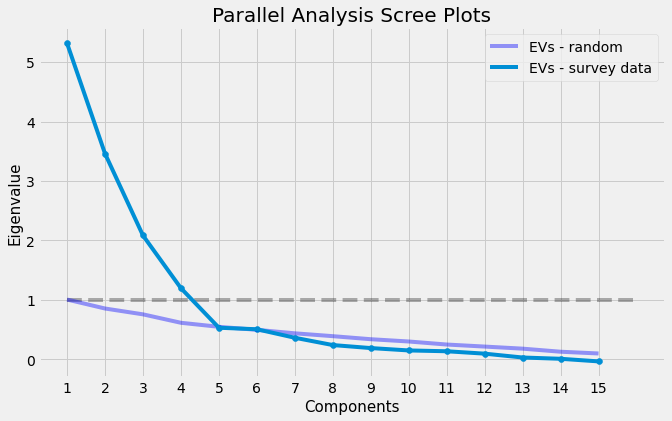

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.01				5.32
2	0.85				3.46
3	0.76				2.08
4	0.61				1.20
5	0.55				0.53
6	0.50				0.51
7	0.44				0.36
8	0.39				0.24
9	0.34				0.19
10	0.30				0.15
11	0.25				0.14
12	0.21				0.10
13	0.18				0.03
14	0.13				0.01
15	0.10				-0.04


In [66]:
parallel_analysis(tss_df, items_analysis_li)

# determine factors to investigate based on screeplot and parallel analysis
# if both methods yield different results, examine both number of factors
# (decide for one based on whether you get a clean solution and on how interpretable the solution is)

In [67]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=4, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)
# If matrix has clear correlations between factors, than this indicates the need for an oblique rotation
# if in doubt use oblique


Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.07810067 -0.27686373  0.12995107]
 [ 0.07810067  1.          0.12700796 -0.20843498]
 [-0.27686373  0.12700796  1.         -0.06861451]
 [ 0.12995107 -0.20843498 -0.06861451  1.        ]]


In [68]:
def iterative_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                  comm_thresh=0.2, main_thresh=0.4, cross_thres=0.3, load_diff_thresh=0.2,
                  print_details=False, print_par_plot=False, print_par_table=False,
                  par_k=100, par_n_facs=15):
    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    final_solution = False

    curr_vars = copy.deepcopy(vars_analsis)

    i = 1
    while final_solution == False:
        # Fit EFA
        efa.fit(data[curr_vars])
        print("Fitted solution #{}\n".format(i))

        # print screeplot and/or table for parallel analysis if option was chosen
        # but not for first run (assuming it was already checked to select number of factors)
        if (i > 1) and print_par_plot or print_par_table:
            parallel_analysis(data, curr_vars, k=par_k, facs_to_display=par_n_facs,
                              print_graph=print_par_plot, print_table=print_par_table)

        # Check 1: Check communcalities
        print("Checking for low communalities")
        comms = pd.DataFrame(efa.get_communalities(
        ), index=tss_df[curr_vars].columns, columns=['Communality'])
        mask_low_comms = comms["Communality"] < comm_thresh

        if comms[mask_low_comms].empty:
            print("All communalities above {}\n".format(comm_thresh))
        else:
            # save bad items and remove them
            bad_items = comms[mask_low_comms].index
            print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nCommunality: {:.4f}\n".format(
                        item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)
            i += 1
            continue

        # Check 2: Check for low main loading
        print("Checking for low main loading")
        loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
        max_loadings = abs(loadings).max(axis=1)
        mask_low_main = max_loadings < main_thresh
        if max_loadings[mask_low_main].empty:
            print("All main loadings above {}\n".format(main_thresh))
        else:
            # save bad items and remove them
            bad_items = max_loadings[mask_low_main].index
            print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nMain (absolute) Loading: {:.4f}\n".format(
                        item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)
            i += 1
            continue

        # check 3: Check for high cross loadings
        print("Checking high cross loadings")

        # create df that stores main_load, largest crossload and difference between the two
        crossloads_df = pd.DataFrame(index=curr_vars)

        crossloads_df["main_load"] = abs(loadings).max(axis=1)
        crossloads_df["cross_load"] = abs(loadings).apply(
            lambda row: row.nlargest(2).values[-1], axis=1)
        crossloads_df["diff"] = crossloads_df["main_load"] - \
            crossloads_df["cross_load"]

        mask_high_cross = (crossloads_df["cross_load"] > cross_thres) | (
            crossloads_df["diff"] < load_diff_thresh)

        if crossloads_df[mask_high_cross].empty:
            print("All cross_loadins loadings below {}".format(cross_thres),
                  "and differences between main loading and crossloadings above {}.\n".format(load_diff_thresh))
        else:
            # save bad items and remove them
            bad_items = crossloads_df[mask_high_cross].index
            print("Detected {} items with high cross loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nLoadings: \n{}\n".format(
                        item, items_descr[item], loadings.loc[item]))
                curr_vars.remove(item)
            i += 1
            continue

        print("Final solution reached.")
        final_solution = True

        corrs = data[curr_vars].corr()
        det = np.linalg.det(corrs)
        print("\nDeterminant of correlation matrix: {}".format(det))
        if det > 0.00001:
            print("Determinant looks good!")
        else:
            print("Determinant is smaller than 0.00001!")
            print(
                "Consider using stricer criteria and/or removing highly correlated vars")

        kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
        print("Overall KMO: {}".format(kmo[1]))

        i = 0
        low_item_kmo = False
        for item_kmo in kmo[0]:
            if item_kmo < .6:
                low_item_kmo = True
                item_label = curr_vars[i]
                print("Low KMO for {} ('{}'): {}".format(
                    item_label, items_descr[item_label], item_kmo))
            i += 1
        if low_item_kmo == False:
            print("All item KMOs are >.6")

# Determinant should be > .00001

    return(efa, curr_vars)

# print relevant loadings for each factor to output


def print_sorted_loadings(efa, item_lables, load_thresh=0.4, descr=[]):
    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    if len(descr) > 0:
        loadings["descr"] = loadings.apply(lambda x: descr[x.name], axis=1)

    for i in range(0, n_load):
        mask_relev_loads = abs(loadings[i]) > load_thresh
        sorted_loads = loadings[mask_relev_loads].sort_values(
            i, key=abs, ascending=False)
        print("Relevant loadings for factor {}".format(i))
        if len(descr) > 0:
            print(sorted_loads[[i, "descr"]].to_string(), "\n")
        else:
            print(sorted_loads[i].to_string(), "\n")


def rev_items_and_return(df, efa, item_lables, load_thresh=0.4, min_score=1, max_score=5):

    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    items_per_fact_dict = {}

    # loop through n factors
    # determine relevant items that are positive (can just be used as is)
    # and items with negative loads (need to be refersed)
    for i in range(0, n_load):
        mask_pos_loads = loadings[i] > load_thresh
        mask_neg_loads = loadings[i] < -load_thresh
        pos_items = loadings[mask_pos_loads].index.tolist()
        neg_items = loadings[mask_neg_loads].index.tolist()

        # add items with positive items directly to dict
        items_per_fact_dict[i] = pos_items

        # create reverse-coded item in df for items with negative loadings
        for item in neg_items:
            rev_item_name = item + "_rev"
            df[rev_item_name] = (df[item] - (max_score+min_score)) * -1
            items_per_fact_dict[i].append(rev_item_name)

    return items_per_fact_dict

Fitted solution #1

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_conch_4: The way the characters were described was inconsistent.
Communality: 0.1942

Fitted solution #2



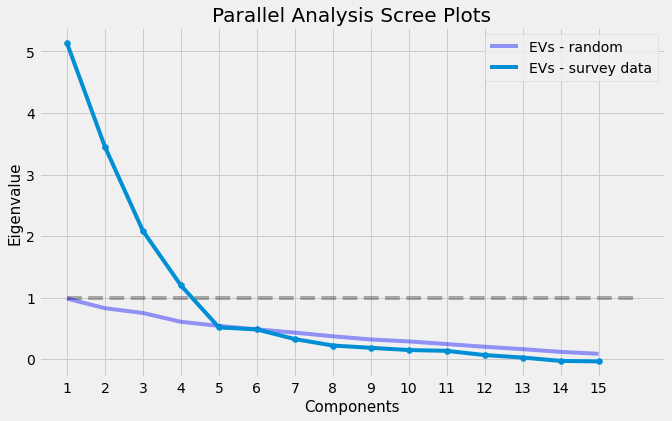

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 2 items with low main loading. Excluding them for next analysis.

Removed item tss_sty_8: The writing style was too complicated to be understood easily.
Main (absolute) Loading: 0.3629

Removed item tss_pac_9: There's nothing superfluous or unnecessary in this story.
Main (absolute) Loading: 0.3689

Fitted solution #3



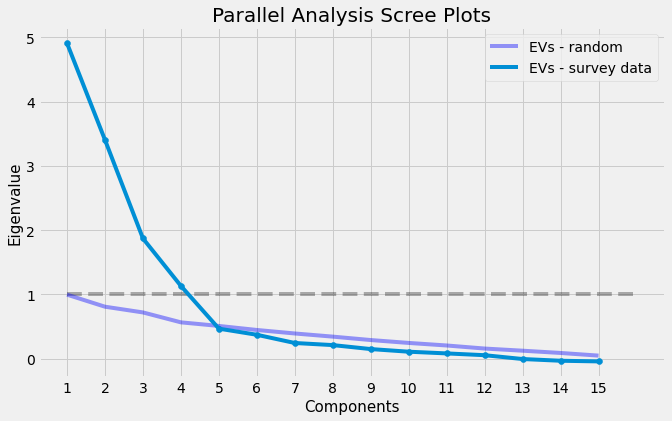

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_sty_9: The story contained a great deal of detail.
Communality: 0.1937

Fitted solution #4



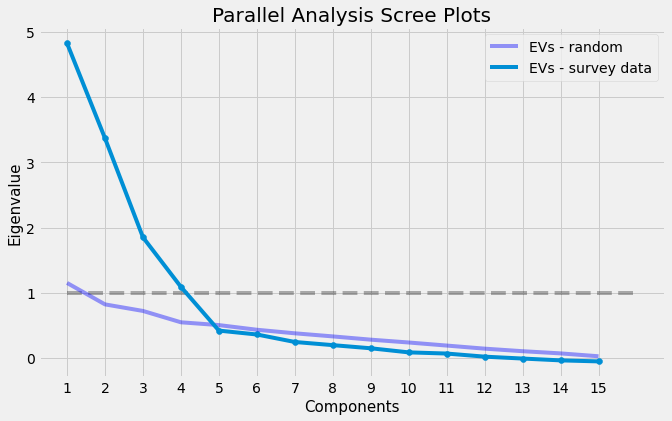

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 8 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Loadings: 
0   -0.520245
1    0.040052
2    0.463003
3    0.116066
Name: tss_coh_9, dtype: float64

Removed item tss_cre_6: It was surprising how things turned out in the story.
Loadings: 
0   -0.197899
1    0.453298
2   -0.038083
3   -0.348417
Name: tss_cre_6, dtype: float64

Removed item tss_cre_7: There were interesting twists and turns in the story.
Loadings: 
0    0.013959
1    0.599232
2    0.048712
3   -0.396334
Name: tss_cre_7, dtype: float64

Removed item tss_qua_7: I would like to read more stories like this one.
Loadings: 
0    0.397189
1    0.591449
2   -0.184601
3   -0.028992
Name: tss_qua_7, dtype: float64

Removed item tss_rep_2: This story avoided repetition.
Loadings: 


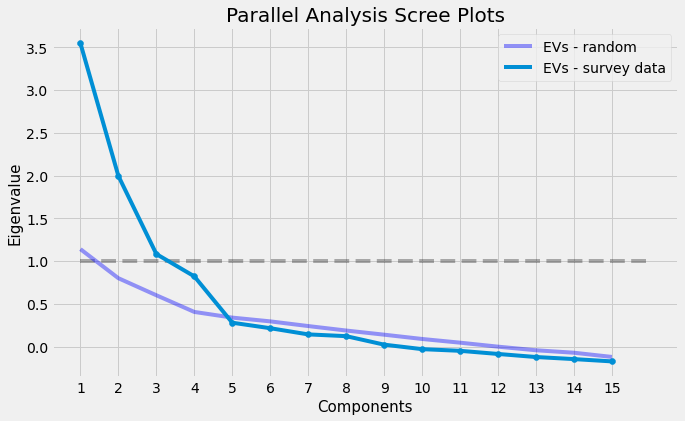

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.005669969476123056
Determinant looks good!
Overall KMO: 0.7900394944780833
Low KMO for tss_sty_5 ('The story used complex vocabulary.'): 0.5926684311028242


In [69]:
four_facs = iterative_efa(tss_df, items_analysis_li, n_facs=4, rotation_method="Varimax", print_details=True,
                          print_par_plot=True)

In [70]:
efa_4 = four_facs[0]
items_4 = four_facs[1]

print_sorted_loadings(efa_4, items_4, load_thresh=0.32, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_6    0.719424                                     The story felt like a coherent story.
tss_coh_4    0.684004                                      The plot of the story was plausible.
tss_coh_11   0.623292                                              The story had a clear theme.
tss_conch_8  0.595366  It was easy to understand the motivation of the characters in the story.
tss_pac_8    0.593484                      All elements of the story were relevant to the plot.
tss_cre_3    0.564433                        The plot development in the story was predictable.
tss_coh_3    0.564312                                   The story appeared to be a single plot.
tss_pac_7   -0.515794                  Many things seemed to be happening at once in the story.
tss_conch_7 -0.459491                     How characters in the story acted seemed implausible. 

Relevan

In [71]:
items_per_fac_4 = rev_items_and_return(tss_df, efa_4, items_4)

for factor_n in items_per_fac_4:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_4[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...

Internal consistency for factor 0:
Cronbachs alpha = 0.8285, 95% CI = [0.79, 0.86]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.8149
tss_coh_4: 0.7995
tss_coh_6: 0.7950
tss_coh_11: 0.8093
tss_conch_8: 0.8099
tss_cre_3: 0.8148
tss_pac_8: 0.8144
tss_conch_7_rev: 0.8214
tss_pac_7_rev: 0.8189


Internal consistency for factor 1:
Cronbachs alpha = 0.6728, 95% CI = [0.60, 0.74]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6324
tss_pac_3: 0.5766
tss_pac_5: 0.5522
tss_pac_1_rev: 0.6559


Internal consistency for factor 2:
Cronbachs alpha = 0.6696, 95% CI = [0.59, 0.74]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.5023
tss_rep_9: 0.5167
tss_rep_11: 0.6866


Internal consistency for factor 3:
Cronbachs alpha = 0.5731, 95% CI = [0.47, 0.66]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.4910
tss_cre_12: 0.3481
tss_sty_5: 0.5630




In [72]:
items_4_2 = copy.deepcopy(items_4)
# items_4_2.remove("tss_rep_11")
items_4_2.extend(["tss_rep_1", "tss_rep_4", "tss_rep_5",
                  "tss_rep_6", "tss_rep_7", "tss_rep_10", "tss_rep_12"])
items_4_2.extend(["tss_cre_1", "tss_cre_2", "tss_cre_4",
                  "tss_cre_5", "tss_cre_8", "tss_cre_10", "tss_cre_11"])
items_4_2.extend(["tss_pac_2", "tss_pac_4"])

In [73]:
items_4_2 = reduce_multicoll(
    tss_df, items_4_2, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 1.657517357590094e-08

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_cre_4. VIF: 24.99
('The story was creative.')

Excluded item tss_rep_5. VIF: 20.80
('In the story, the same things happened again and again.')

Excluded item tss_rep_12. VIF: 19.41
('Particular words were used too often in the story.')

Excluded item tss_rep_4. VIF: 19.34
('The story was very repetitive.')

Excluded item tss_cre_5. VIF: 18.48
('The story was imaginative.')

Excluded item tss_cre_2. VIF: 18.37
('The story was boring.')

Excluded item tss_rep_10. VIF: 15.94
('Characters said or did the same thing many times over.')

Done! Determinant is now: 0.000022
I have excluded 7 redunant items with 28 items remaining


Fitted solution #1

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_sty_5: The story used complex vocabulary.
Communality: 0.1876

Fitted solution #2



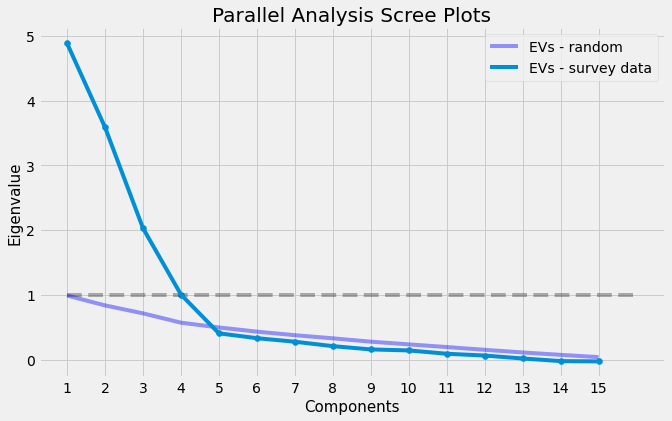

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 5 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_6: The story felt like a coherent story.
Loadings: 
0    0.690475
1    0.307314
2   -0.134100
3    0.107994
Name: tss_coh_6, dtype: float64

Removed item tss_pac_1: The story moved at a fast pace.
Loadings: 
0   -0.316170
1    0.074942
2    0.026401
3   -0.515154
Name: tss_pac_1, dtype: float64

Removed item tss_cre_1: The story felt dynamic.
Loadings: 
0   -0.046319
1    0.531960
2   -0.130632
3   -0.346091
Name: tss_cre_1, dtype: float64

Removed item tss_cre_10: The story was unconventional.
Loadings: 
0   -0.465038
1    0.387527
2    0.090414
3    0.005262
Name: tss_cre_10, dtype: float64

Removed item tss_pac_4: The story dragged on and on.
Loadings: 
0    0.010277
1   -0.160847
2    0.461001
3    0.438658
Name: tss_pac_4, dtype: float64



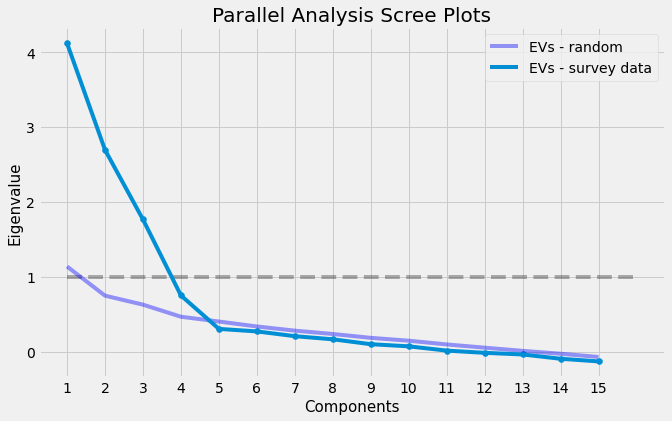

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0005254512576137883
Determinant looks good!
Overall KMO: 0.8065740082880333
All item KMOs are >.6


In [74]:
four_facs_2 = iterative_efa(tss_df, items_4_2, n_facs=4, rotation_method="Varimax", print_details=True,
                            print_par_plot=True)

In [75]:
efa_4_2 = four_facs_2[0]
items_4_2 = four_facs_2[1]

print_sorted_loadings(efa_4_2, items_4_2, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_4    0.672132                                      The plot of the story was plausible.
tss_cre_3    0.635264                        The plot development in the story was predictable.
tss_coh_11   0.604200                                              The story had a clear theme.
tss_coh_3    0.583220                                   The story appeared to be a single plot.
tss_pac_8    0.551689                      All elements of the story were relevant to the plot.
tss_conch_8  0.546086  It was easy to understand the motivation of the characters in the story.
tss_pac_7   -0.524465                  Many things seemed to be happening at once in the story.
tss_cre_11   0.502539                              The plot was typical for this kind of story.
tss_conch_7 -0.434169                     How characters in the story acted seemed implausible. 

Relevan

In [76]:
items_per_fac_4_2 = rev_items_and_return(tss_df, efa_4_2, items_4_2)

for factor_n in items_per_fac_4_2:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_4_2[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

Internal consistency for factor 0:
Cronbachs alpha = 0.8055, 95% CI = [0.77, 0.84]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.7850
tss_coh_4: 0.7722
tss_coh_11: 0.7802
tss_conch_8: 0.7847
tss_cre_3: 0.7824
tss_pac_8: 0.7879
tss_cre_11: 0.7950
tss_conch_7_rev: 0.7976
tss_pac_7_rev: 0.7906


Internal consistency for factor 1:
Cronbachs alpha = 0.8149, 95% CI = [0.77, 0.85]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.7591
tss_rep_9: 0.7671
tss_rep_11: 0.8346
tss_rep_6: 0.7496
tss_rep_7: 0.7755


Internal consistency for factor 2:
Cronbachs alpha = 0.7820, 95% CI = [0.73, 0.82]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.8022
tss_cre_12: 0.7348
tss_rep_1: 0.7247
tss_cre_8: 0.7284
tss_pac_2: 0.7105


Internal consistency for factor 3:
Cronbachs alpha = 0.6559, 95% CI = [0.57, 0.73]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.5747
tss_pac_3: 0.6416
tss_pac_5: 0.4505




In [77]:
items_per_fac_4_2[1].remove("tss_rep_11")
items_per_fac_4_2[2].remove("tss_cre_9")
items_per_fac_4_2

{0: ['tss_coh_3',
  'tss_coh_4',
  'tss_coh_11',
  'tss_conch_8',
  'tss_cre_3',
  'tss_pac_8',
  'tss_cre_11',
  'tss_conch_7_rev',
  'tss_pac_7_rev'],
 1: ['tss_rep_3', 'tss_rep_9', 'tss_rep_6', 'tss_rep_7'],
 2: ['tss_cre_12', 'tss_rep_1', 'tss_cre_8', 'tss_pac_2'],
 3: ['tss_rep_8', 'tss_pac_3', 'tss_pac_5']}

In [78]:
# compute scale means but only if at least 66% of questions are answered
mask_suff_data_coh = tss_df[items_per_fac_4_2[0]].isna().sum(
    axis=1) <= round(len(items_per_fac_4_2[0])/3)
mask_suff_data_rep = tss_df[items_per_fac_4_2[1]].isna().sum(
    axis=1) <= round(len(items_per_fac_4_2[1])/3)
mask_suff_data_cre = tss_df[items_per_fac_4_2[2]].isna().sum(
    axis=1) <= round(len(items_per_fac_4_2[2])/3)
mask_suff_data_pac = tss_df[items_per_fac_4_2[3]].isna().sum(
    axis=1) <= round(len(items_per_fac_4_2[3])/3)
tss_df["tss_coh"] = tss_df[mask_suff_data_coh][items_per_fac_4_2[0]].mean(
    axis=1)
tss_df["tss_rep"] = tss_df[mask_suff_data_rep][items_per_fac_4_2[1]].mean(
    axis=1)
tss_df["tss_cre"] = tss_df[mask_suff_data_cre][items_per_fac_4_2[2]].mean(
    axis=1)
tss_df["tss_pac"] = tss_df[mask_suff_data_pac][items_per_fac_4_2[3]].mean(
    axis=1)

# Some scales might make more sense fully reversed
tss_df["tss_pac"] = (tss_df["tss_pac"]-6)*-1
tss_df["tss_avoid_rep"] = (tss_df["tss_rep"]-6)*-1

In [79]:
# if you actually have missing data, double check if this worked as intended
tss_df[~mask_suff_data_cre]

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,pass_qual_1,pass_qual_2,tss_conch_7_rev,tss_pac_7_rev,tss_pac_1_rev,tss_coh,tss_rep,tss_cre,tss_pac,tss_avoid_rep


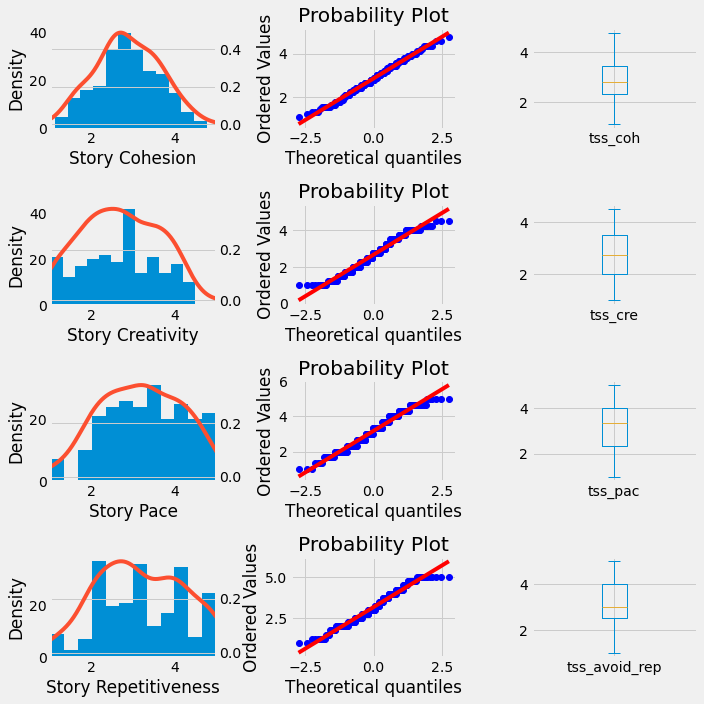

In [80]:
# Check scale distributions
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

# Histograms with KDE
ax1 = tss_df["tss_coh"].plot.hist(ax=axes[0, 0], bins=12)
ax1.set_xlabel("Story Cohesion")
ax1.set_xlim(1, 5)
tss_df["tss_coh"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = tss_df["tss_cre"].plot.hist(ax=axes[1, 0], bins=12)
ax2.set_xlabel("Story Creativity")
ax2.set_xlim(1, 5)
tss_df["tss_cre"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = tss_df["tss_pac"].plot.hist(ax=axes[2, 0], bins=12)
tss_df["tss_pac"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Story Pace")
ax3.set_xlim(1, 5)

ax4 = tss_df["tss_avoid_rep"].plot.hist(ax=axes[3, 0], bins=12)
tss_df["tss_avoid_rep"].plot.kde(ax=axes[3, 0], secondary_y=True)
ax4.set_xlabel("Story Repetitiveness")
ax4.set_xlim(1, 5)

# Q-Q Plots
stats.probplot(tss_df["tss_coh"], dist="norm", plot=axes[0, 1])
stats.probplot(tss_df["tss_cre"], dist="norm", plot=axes[1, 1])
stats.probplot(tss_df["tss_pac"], dist="norm", plot=axes[2, 1])
stats.probplot(tss_df["tss_avoid_rep"], dist="norm", plot=axes[3, 1])

# Boxplots
tss_df["tss_coh"].plot.box(ax=axes[0, 2])
tss_df["tss_cre"].plot.box(ax=axes[1, 2])
tss_df["tss_pac"].plot.box(ax=axes[2, 2])
tss_df["tss_avoid_rep"].plot.box(ax=axes[3, 2])

fig.tight_layout()
plt.show()

In [81]:
tss_df[["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]].corr()

,tss_coh,tss_cre,tss_avoid_rep,tss_pac
tss_coh,1.000000,0.244301,0.123783,-0.019717
tss_cre,0.244301,1.000000,0.254947,0.305980
tss_avoid_rep,0.123783,0.254947,1.000000,0.291285
tss_pac,-0.019717,0.305980,0.291285,1.000000


<Figure size 720x720 with 0 Axes>

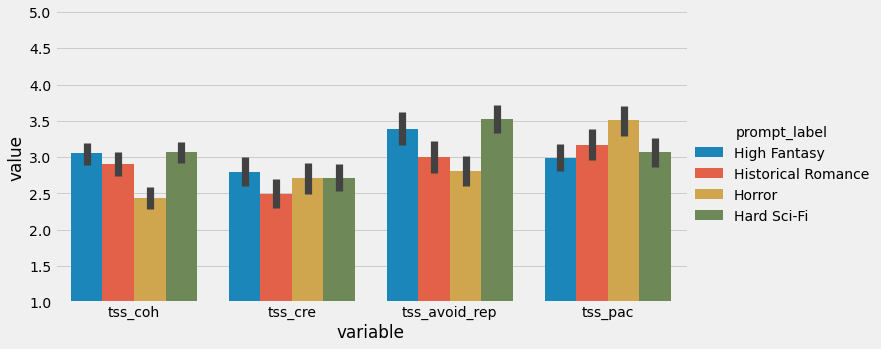

In [82]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "prompt_label", "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]
              ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<Figure size 720x720 with 0 Axes>

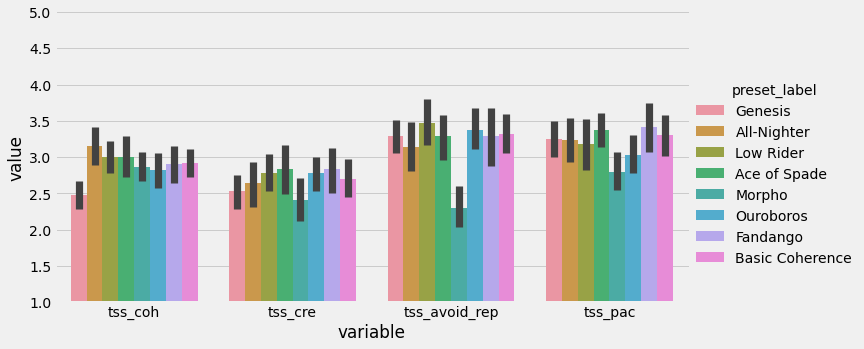

In [83]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "preset_label", "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]
              ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<AxesSubplot:xlabel='word_count', ylabel='tss_cre'>

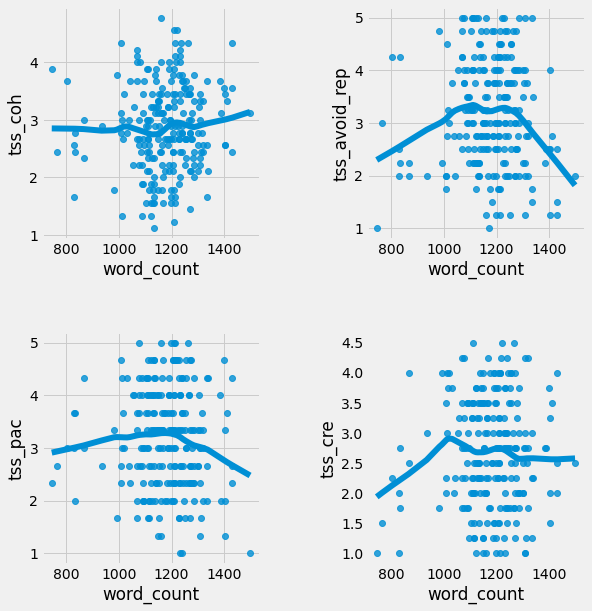

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_df, y="tss_coh",
            x="word_count", lowess=True, ax=axes[0, 0])
sns.regplot(data=tss_df, y="tss_avoid_rep",
            x="word_count", lowess=True, ax=axes[0, 1])
sns.regplot(data=tss_df, y="tss_pac",
            x="word_count", lowess=True, ax=axes[1, 0])
sns.regplot(data=tss_df, y="tss_cre",
            x="word_count", lowess=True, ax=axes[1, 1])

In [85]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["words_cent"] = tss_df["word_count"].apply(
    lambda x: x-tss_df["word_count"].mean())  # centering

tss_df["words_cent**2"] = tss_df["words_cent"]*tss_df["words_cent"]
tss_df["words_cent**3"] = tss_df["words_cent"]**3
#tss_df["words_cent**4"] = tss_df["words_cent"]**4
#tss_df["words_cent**5"] = tss_df["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent**2"),
           ("cubic", "words_cent**3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA

Model performance for linear model predicting tss_coh:
r-square: -0.0772    RMSE: 0.7534
Model performance for quadratic model predicting tss_coh:
r-square: -0.0777    RMSE: 0.7534
Model performance for cubic model predicting tss_coh:
r-square: -0.0882    RMSE: 0.7566

Model performance for linear model predicting tss_cre:
r-square: -0.0759    RMSE: 0.9125
Model performance for quadratic model predicting tss_cre:
r-square: -0.0646    RMSE: 0.9081
Model performance for cubic model predicting tss_cre:
r-square: -0.0451    RMSE: 0.8998

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0500    RMSE: 1.0227
Model performance for quadratic model predicting tss_avoid_rep:
r-square: -0.0086    RMSE: 0.9985
Model performance for cubic model predicting tss_avoid_rep:
r-square: -0.0137    RMSE: 1.0017

Model performance for linear model predicting tss_pac:
r-square: -0.0363    RMSE: 0.9562
Model performance for quadratic model predicting tss_pac:
r-square: -0.0242    RMSE

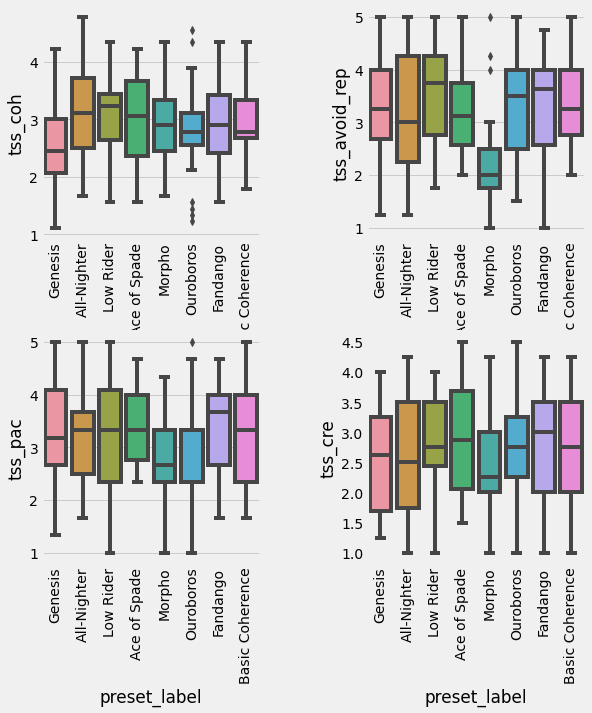

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="preset_label", y="tss_coh", data=tss_df, ax=axes[0, 0])
sns.boxplot(x="preset_label", y="tss_avoid_rep", data=tss_df, ax=axes[0, 1])
sns.boxplot(x="preset_label", y="tss_pac", data=tss_df, ax=axes[1, 0])
sns.boxplot(x="preset_label", y="tss_cre", data=tss_df, ax=axes[1, 1])

for ax_1, ax_2 in axes:
    ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation=90)
    ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation=90)

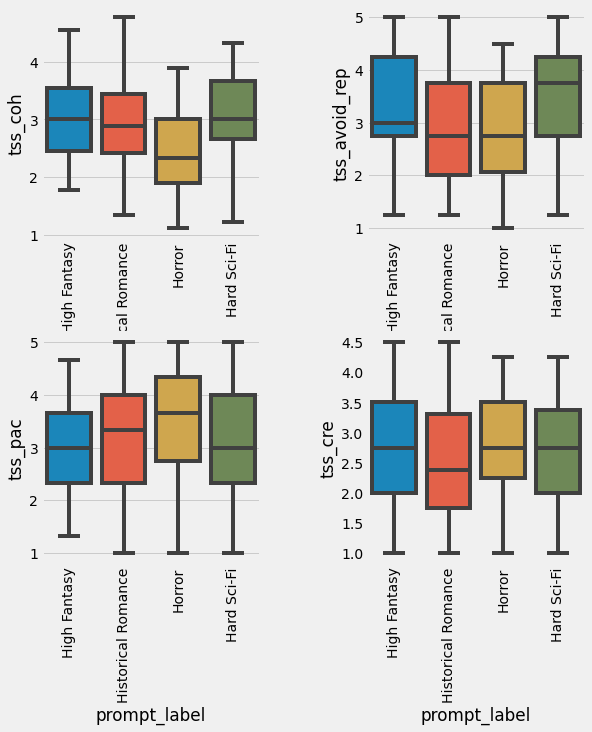

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="tss_coh", data=tss_df, ax=axes[0, 0])
sns.boxplot(x="prompt_label", y="tss_avoid_rep", data=tss_df, ax=axes[0, 1])
sns.boxplot(x="prompt_label", y="tss_pac", data=tss_df, ax=axes[1, 0])
sns.boxplot(x="prompt_label", y="tss_cre", data=tss_df, ax=axes[1, 1])

for ax_1, ax_2 in axes:
    ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation=90)
    ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation=90)

In [88]:
def determine_outliers(df, var, distance=3, mode="print"):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)

    iqr = q3-q1
    outlier_lower = q1 - (iqr*distance)
    outlier_upper = q3 + (iqr*distance)
    if mode == "print":
        print("25th Percentile (Q1): {:.2f}\n75th Percentile (Q3): {:.2f}\nIQR: {:.2f}".format(
            q1, q3, iqr))
        print("Will count cases as outlier with values less than {:.2f} or more than {:.2f}."
              .format(outlier_lower, outlier_upper))
        mask_outlier = (df[var] < outlier_lower) | (df[var] > outlier_upper)
        if df[mask_outlier].shape[0] == 0:
            print("With these criteria there are no outlier in the data")
        else:
            print("Showing outliers")
            print(df[mask_outlier][var])
    else:
        print("Mode must be 'print'")

In [89]:
# Outliers for Presets
# Outliers Coherence
print("Exterme outliers on tss_coh, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_coh")
# Outliers Repitition
print("\nExterme outliers on tss_rep, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_avoid_rep")
# Outliers pace
print("\nExterme outliers on tss_pac, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_pac")

# ## Outliers for Prompts
# print("\nExterme outliers on tss_pac, Horror prompt")
# determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_pac")

Exterme outliers on tss_coh, Ouroboros preset
25th Percentile (Q1): 2.56
75th Percentile (Q3): 3.11
IQR: 0.56
Will count cases as outlier with values less than 0.89 or more than 4.78.
With these criteria there are no outlier in the data

Exterme outliers on tss_rep, Morpho preset
25th Percentile (Q1): 1.75
75th Percentile (Q3): 2.50
IQR: 0.75
Will count cases as outlier with values less than -0.50 or more than 4.75.
Showing outliers
7    5.0
Name: tss_avoid_rep, dtype: float64

Exterme outliers on tss_pac, Ouroboros preset
25th Percentile (Q1): 2.33
75th Percentile (Q3): 3.33
IQR: 1.00
Will count cases as outlier with values less than -0.67 or more than 6.33.
With these criteria there are no outlier in the data


In [90]:
tss_no_out = tss_df[~(tss_df.index == 7)]

In [91]:
# Normality
def qqs_over_groups_and_vars(df, group_label, vars_li, size=(15, 15)):
    groups_li = df[group_label].unique()
    fig, axes = plt.subplots(len(vars_li), len(groups_li), figsize=size)
    fig.tight_layout(pad=5.0)
    plt.grid(False)

    x = 0
    y = 0
    for group, var in itertools.product(groups_li, vars_li):
        stats.probplot(df[df[group_label] == group][var],
                       dist="norm", plot=axes[y, x])
        axes[y, x].set_title(group + " - " + var)
        if x < (len(groups_li)-1):
            x += 1
        else:
            x = 0
            y += 1

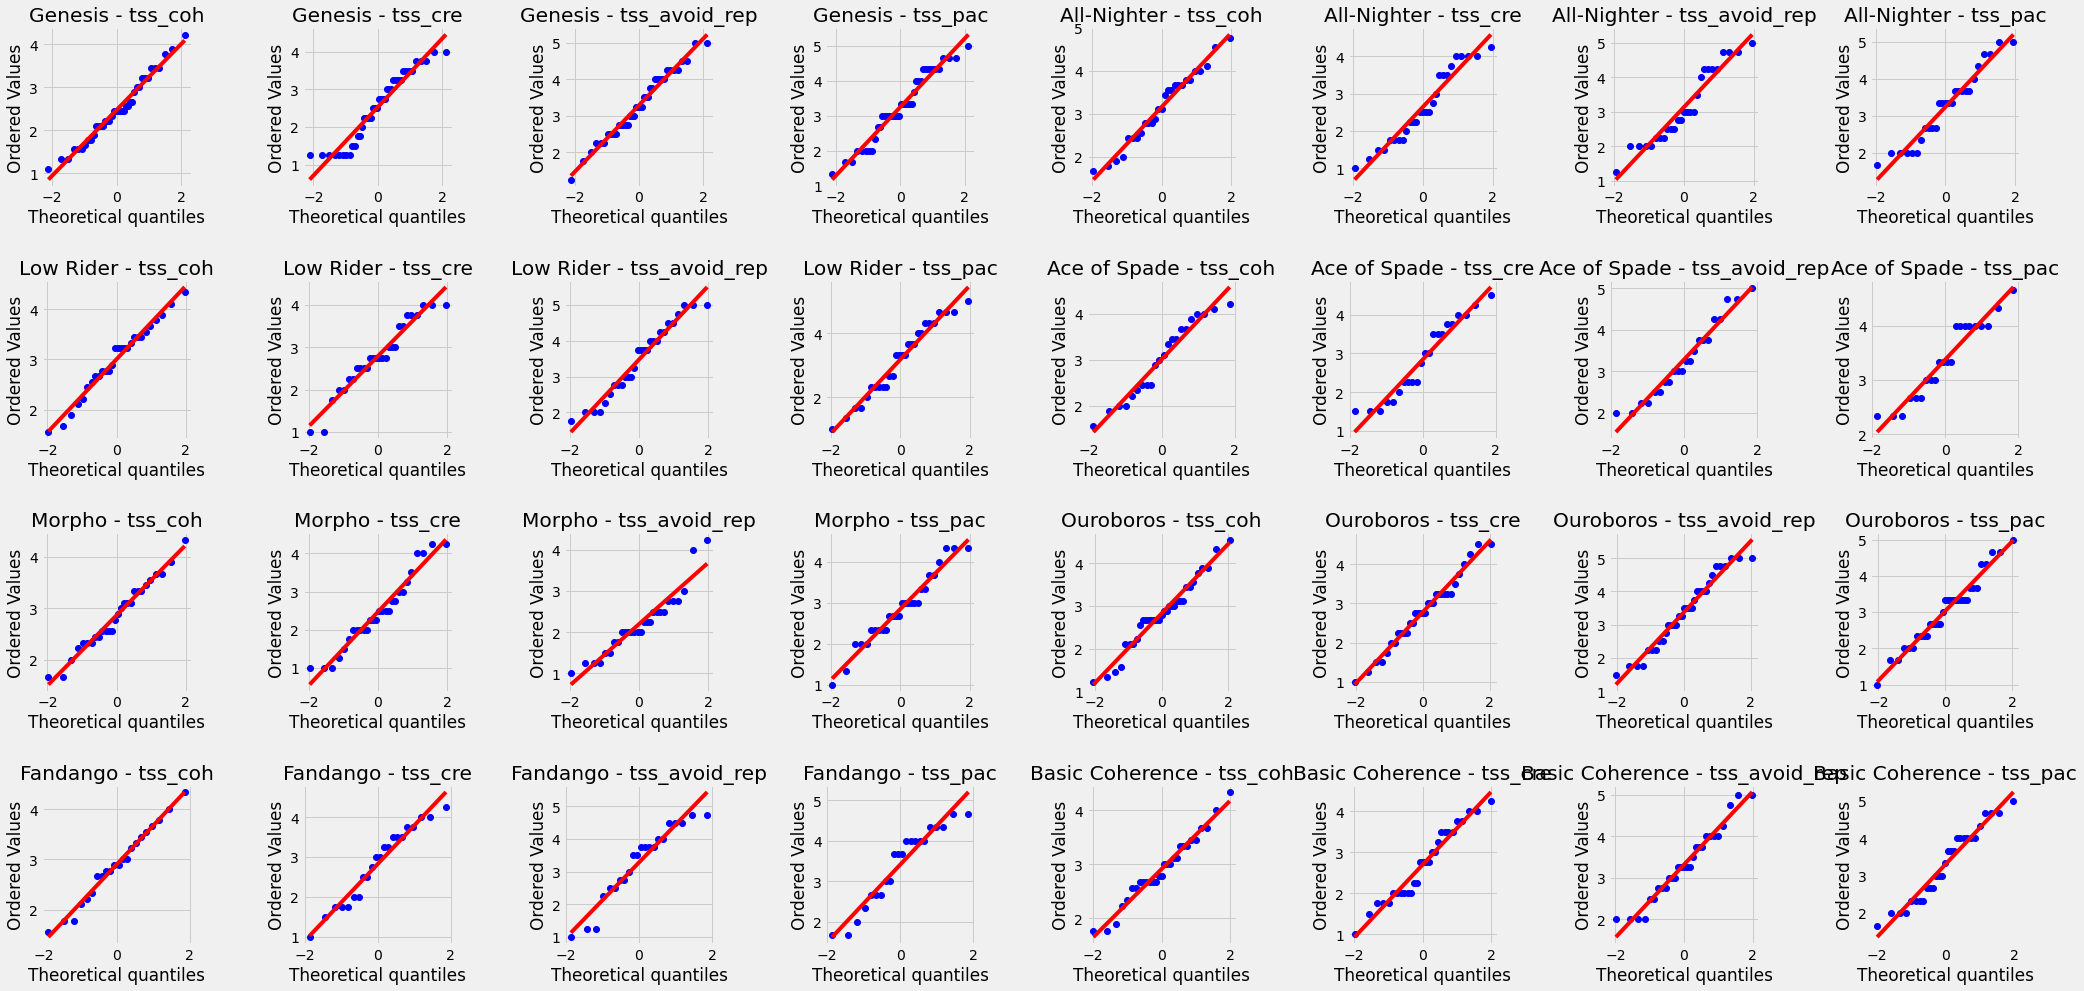

In [92]:
qqs_over_groups_and_vars(tss_no_out, "preset_label", outcome_li, size=(30, 15))

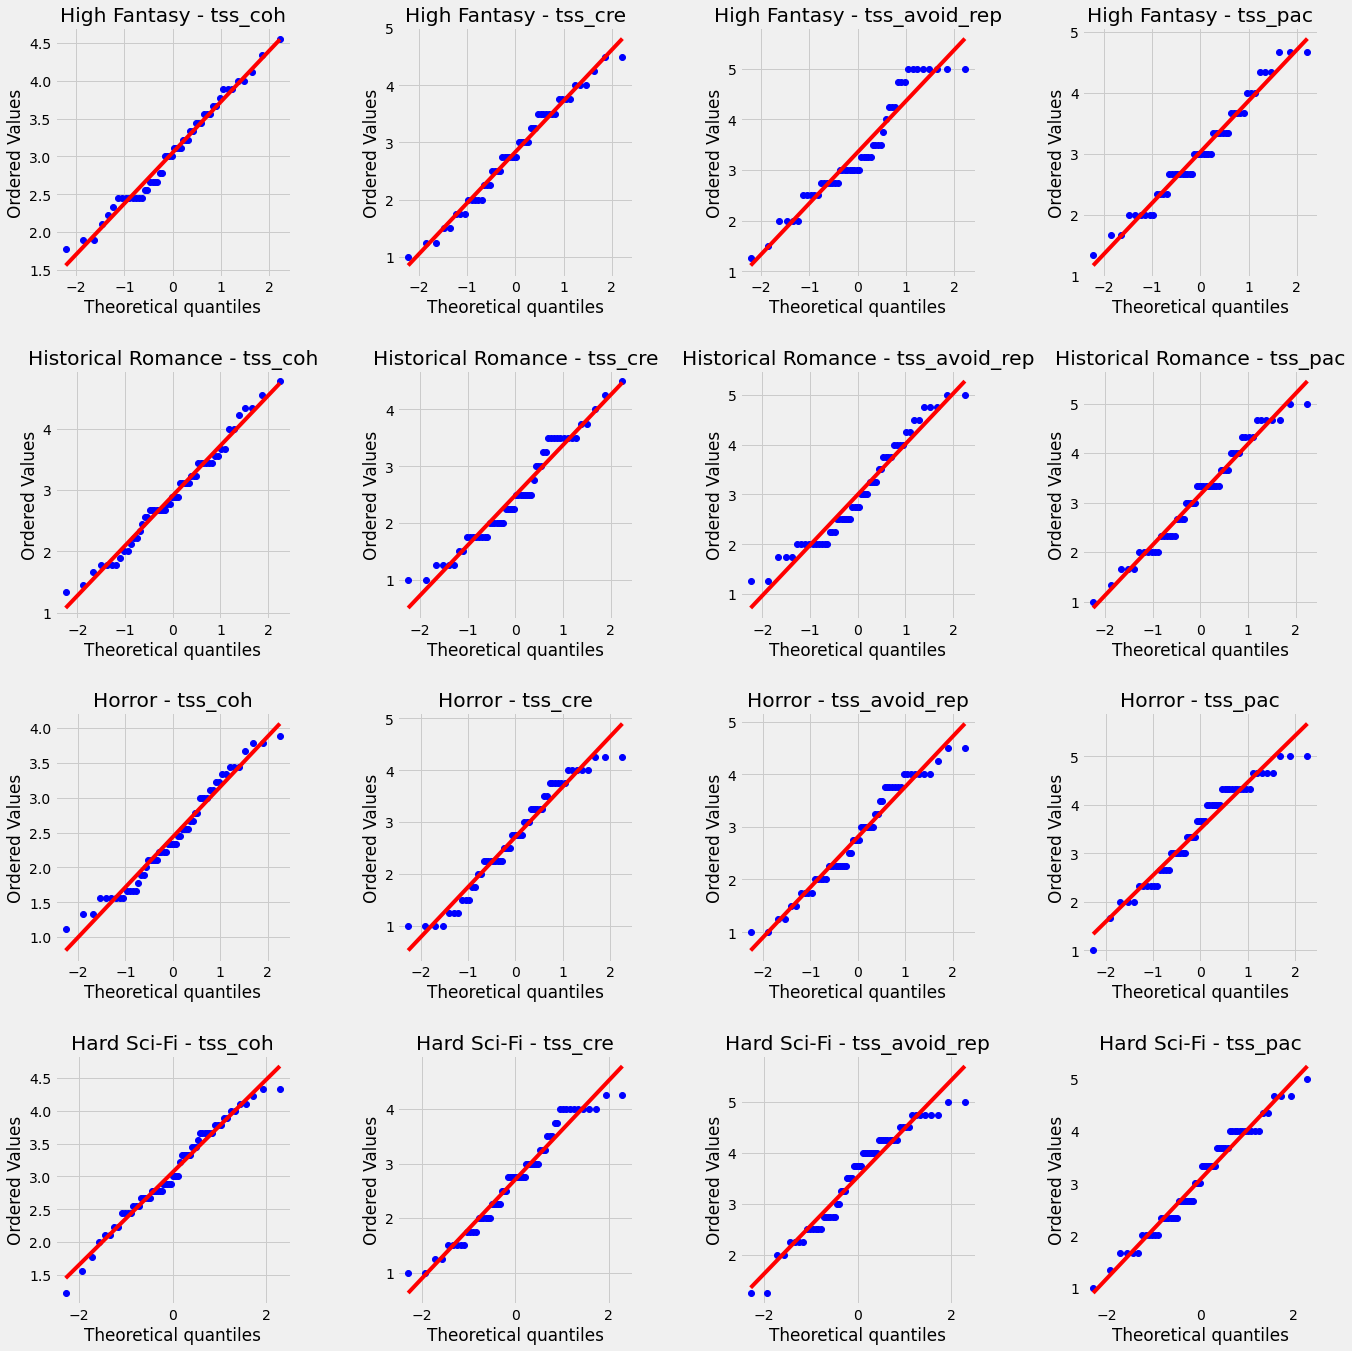

In [93]:
qqs_over_groups_and_vars(tss_no_out, "prompt_label", outcome_li, size=(20, 20))

In [94]:
# Checking if F-test ist robust to heteroscedacity
# Taking recommended approach from Blanca et al., 2018
def anova_check_homoscedacity(y_var, group_var, df):
    var_ser = pd.Series(index=df[group_var].unique(), dtype=float)

    for group in df[group_var].unique():
        var_ser[group] = df[df[group_var] == group][y_var].var()

    min_var = (var_ser.idxmin(), var_ser.min())
    max_var = (var_ser.idxmax(), var_ser.max())
    var_ratio = max_var[1]/min_var[1]
    print("Smallest variance for {}: {:.2f}".format(min_var[0], min_var[1]))
    print("Largest variance for {}: {:.2f}".format(max_var[0], max_var[1]))
    print("Variance ratio for: {:.2f}".format(var_ratio))

    if var_ratio <= 1.5:
        print("Variance ratio is smaller or equal to 1.5, F-test will be robust.")
        return
    else:
        print("Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.")

    # Create dataframe with variance and group sizes
    var_n_df = var_ser.to_frame(name="var")
    var_n_df["n"] = df.value_counts(subset=group_var)
    # get correlation between correlation and variance
    corr_var_n = var_n_df[["var", "n"]].corr().iloc[1, 0]

    if (corr_var_n >= 0) and (corr_var_n <= 0.5):
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is between 0 and .5. F-test should be robust".
              format(corr_var_n))
        return
    else:
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is below 0 or over .5.".
              format(corr_var_n), "Continuing with further checks...")

    # Compute coefficient of sample size variation
    coeff_n = var_n_df["var"].std()/var_n_df["var"].mean()
    if (corr_var_n > 0.5) and (coeff_n > .33) and (var_ratio > 2):
        print("Pairing is {:.2f}, so larger than .5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .33,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too conserative (hurting power)")
    elif (corr_var_n < 0) and (corr_var_n >= -0.5) and (coeff_n > .16) and (var_ratio > 2):
        print("Pairing is {:.2f}, so smaller than 0 and larger than or equal to -.5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .16,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).")
    elif (corr_var_n < -0.5):
        print("Pairing is {:.2f}, so smaller than -.5.".format(corr_var_n),
              "F-test is too liberal (real alpha might be as high as .2 if variance ratio is 9 or smaller).")
    else:
        print("Pairing is {}, coefficient of sample size variation is {:.2f}, variance ratio is {}."
              .format(corr_var_n, coeff_n, var_ratio),
              "This specific combination should have robust F-test, but look into the paper",
              "('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018)",
              "to be sure.")

In [95]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_check_homoscedacity(outcome, "preset_label", tss_no_out)
    print("\nPrompt")
    anova_check_homoscedacity(outcome, "prompt_label", tss_no_out)
    print("\n")

Checks for tss_coh
Preset
Smallest variance for Basic Coherence: 0.38
Largest variance for All-Nighter: 0.70
Variance ratio for: 1.86
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.12. That is below 0 or over .5. Continuing with further checks...
Pairing is -0.11798365833903346, coefficient of sample size variation is 0.21, variance ratio is 1.8573293514404003. This specific combination should have robust F-test, but look into the paper ('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018) to be sure.

Prompt
Smallest variance for High Fantasy: 0.44
Largest variance for Historical Romance: 0.64
Variance ratio for: 1.47
Variance ratio is smaller or equal to 1.5, F-test will be robust.


Checks for tss_cre
Preset
Smallest variance for Low Rider: 0.67
Largest variance for Ace of Spade: 0.97
Variance ratio for: 1.45
Variance ratio is smaller or equal 

In [96]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + \
        " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + \
        " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, tss_no_out).fit(cov_type='HC3')
    anova_mod2 = ols(
        ols_formula2, tss_no_out).fit(cov_type='HC3')
    print(sm.stats.anova_lm(anova_mod, typ=2, robust='HC3'))
    print(anova_mod.summary(alpha=0.1))

    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")

    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7],
                  outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]

    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10],
                  outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]

tss_coh
                             sum_sq     df         F    PR(>F)
C(preset_label, Sum)       7.384304    7.0  2.095719  0.045176
C(prompt_label, Sum)      14.121260    3.0  9.351336  0.000008
C(sample, Treatment(0))    0.028977    1.0  0.057567  0.810610
Residual                 109.229077  217.0       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                tss_coh   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     4.647
Date:                Mon, 21 Mar 2022   Prob (F-statistic):           2.31e-06
Time:                        12:50:42   Log-Likelihood:                -240.18
No. Observations:                 229   AIC:                             504.4
Df Residuals:                     217   BIC:                             545.6
Df Model:                          11        

                             sum_sq     df         F    PR(>F)
C(preset_label, Sum)       8.392909    7.0  1.384255  0.213140
C(prompt_label, Sum)       8.834994    3.0  3.400061  0.018647
C(sample, Treatment(0))    1.976072    1.0  2.281416  0.132387
Residual                 187.956782  217.0       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                tss_pac   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.964
Date:                Mon, 21 Mar 2022   Prob (F-statistic):             0.0332
Time:                        12:50:42   Log-Likelihood:                -302.32
No. Observations:                 229   AIC:                             628.6
Df Residuals:                     217   BIC:                             669.8
Df Model:                          11                

In [97]:
params_df.index = params_df.index.str.replace(
    r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - \
        params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace(
    "90% CI Lower", "90% CI margin", regex=False)

presets_li = list(tss_no_out["preset_label"].unique())
prompts_li = list(tss_no_out["prompt_label"].unique())

order_index = ["Intercept"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_index)

cols_order = []

for outcome in outcome_li:
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]

    cols_order.extend([outcome, outcome + " p-value",
                       outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]

In [98]:
params_df

,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin
Intercept,2.898807,0.000000e+00,NaN,0.110538,2.562351,1.266414e-226,NaN,0.131140,3.337513,0.000000e+00,NaN,0.141642,3.287859,0.000000,NaN,0.141765
Genesis,-0.373240,3.329940e-04,0.002664,0.171097,-0.166363,2.486609e-01,0.818458,0.237207,0.173719,2.188365e-01,4.080414e-01,0.232381,0.007885,0.956089,0.956089,0.235561
All-Nighter,0.213474,1.639255e-01,0.655702,0.252253,-0.027069,8.717454e-01,0.989927,0.275794,-0.096273,5.810738e-01,6.640843e-01,0.286970,0.063335,0.720500,0.907651,0.291168
Low Rider,0.129078,3.405760e-01,0.908203,0.222779,0.100052,5.115363e-01,0.818458,0.250698,0.290441,6.726931e-02,2.690772e-01,0.261075,-0.053566,0.794195,0.907651,0.337752
Ace of Spade,0.100388,4.747132e-01,0.949426,0.230996,0.131163,5.101958e-01,0.818458,0.327614,0.104874,5.441656e-01,6.640843e-01,0.284410,0.192718,0.185680,0.558432,0.239517
Morpho,-0.003232,9.786753e-01,0.978675,0.198904,-0.237172,1.537773e-01,0.818458,0.273511,-0.939357,7.913985e-13,6.331188e-12,0.215717,-0.376948,0.014835,0.118679,0.254485
Ouroboros,-0.063117,6.035489e-01,0.965678,0.199918,0.058044,6.852007e-01,0.913601,0.235518,0.210538,2.117090e-01,4.080414e-01,0.277292,-0.173032,0.299283,0.598567,0.274201
Fandango,-0.025267,8.670393e-01,0.978675,0.248245,0.143322,4.685550e-01,0.818458,0.325240,0.083606,6.870568e-01,6.870568e-01,0.341364,0.240256,0.209412,0.558432,0.314843
Basic Coherence,0.021917,8.475928e-01,0.978675,0.187579,-0.001976,9.899271e-01,0.989927,0.257482,0.172452,2.550259e-01,4.080414e-01,0.249210,0.099351,0.541782,0.866852,0.267846
High Fantasy,0.183712,3.087908e-02,0.041172,0.139987,0.153732,1.528072e-01,0.305614,0.176869,0.191157,7.160534e-02,9.547379e-02,0.174523,-0.149998,0.165560,0.245788,0.177933


In [99]:
tss_no_out["preset_label"].value_counts()

Genesis            40
Ouroboros          33
Basic Coherence    29
Low Rider          28
Morpho             28
All-Nighter        27
Ace of Spade       22
Fandango           22
Name: preset_label, dtype: int64

In [100]:
# labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# # create dicts with a key for each preset with an empty list as value for each
# marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
# yerr_dict = {preset: [] for preset in params_df[1:8].index}
# #colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

# for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
#     marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
#     yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

# figure = plt.figure(figsize=(10, 5))

# x = np.arange(len(labels)) # label locations
# width = 0.35 # width of bars

# plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
#         yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")
# plt.bar(x+width/2, marginal_means_dict["Ouroboros"], width,
#         yerr = yerr_dict["Ouroboros"], label = "Ouroboros", color = "tab:orange")


# i = 0
# pos = -0.4
# for outcome in outcome_li:
#     grand_mean = params_df.loc["Intercept", outcome]
#     ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
#     if i == 0:
#         ax[0].set_label("Grand Mean (all Presets)")
#     i += 1
#     pos += 1

# plt.ylim(1,5)
# plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
# plt.xticks(x, labels, fontsize = 16)

# plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
# leg = plt.gca().get_legend()
# plt.grid(False)
# #plt.title("Genesis & Low Rider")
# #figure.tight_layout()
# plt.show()

# figure.savefig('graphs/gen_our_1.png', bbox_inches="tight")

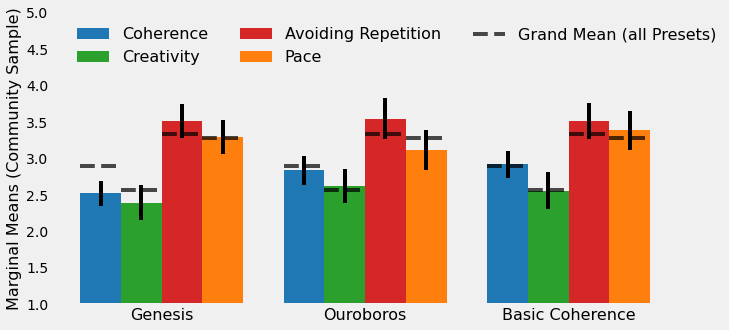

In [124]:
labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}
colors = ["darkblue", "darkgreen", "darkred", "darkorange"]

for preset, outcome in itertools.product(["Genesis", "Ouroboros", "Basic Coherence"], outcome_li):
    marginal_means_dict[outcome].append(
        params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
    yerr_dict[outcome].append(
        params_df.loc[preset, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.2  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.1, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Creativity", color="tab:green")

plt.bar(x+0.1, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.3, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, ["Genesis", "Ouroboros", "Basic Coherence"], fontsize=16)

outcome_i = 0
pos = -0.4
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    for preset_i in range(0, len(plt.gca().get_xticks())):
        ax = plt.plot([pos+preset_i, pos+width+preset_i],
                      [grand_mean, grand_mean], '--', color="black", alpha=0.7)
    if outcome_i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    outcome_i += 1
    pos += width


handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.55, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_presets_preview.png', bbox_inches="tight")

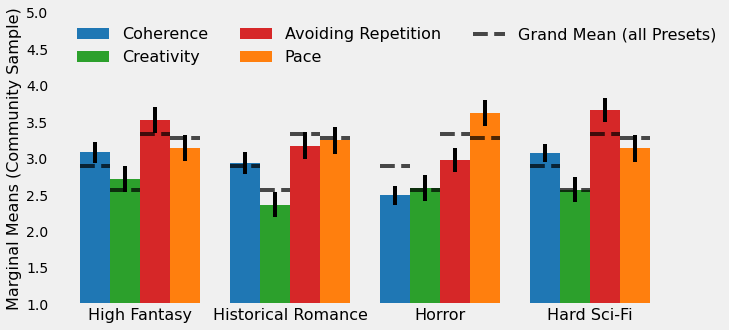

In [123]:
# Create graph for prompts

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}
colors = ["darkblue", "darkgreen", "darkred", "darkorange"]

for prompt, outcome in itertools.product(prompts_li, outcome_li):
    marginal_means_dict[outcome].append(
        params_df.loc["Intercept", outcome] + params_df.loc[prompt, outcome])
    yerr_dict[outcome].append(
        params_df.loc[prompt, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.2  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.1, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Creativity", color="tab:green")

plt.bar(x+0.1, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.3, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, prompts_li, fontsize=16)

outcome_i = 0
pos = -0.4
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    for preset_i in range(0, len(plt.gca().get_xticks())):
        ax = plt.plot([pos+preset_i, pos+width+preset_i],
                      [grand_mean, grand_mean], '--', color="black", alpha=0.7)
    if outcome_i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    outcome_i += 1
    pos += width


handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.55, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_prompts.png', bbox_inches="tight")

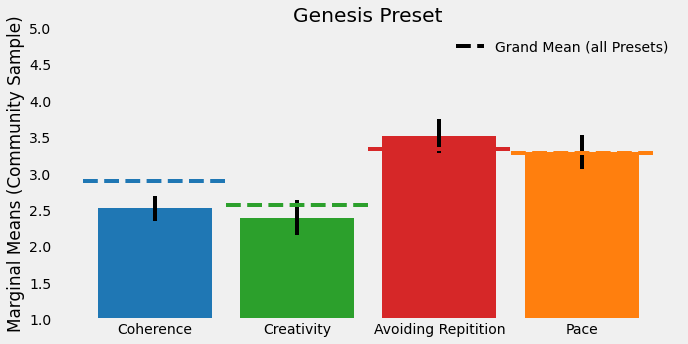

In [125]:
genesis_marginal_means = []
genesis_yerr = []
colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

for outcome in outcome_li:
    genesis_marginal_means.append(params_df.loc["Intercept", outcome] + params_df.loc["Genesis", outcome])
    genesis_yerr.append(params_df.loc["Genesis", outcome + " 90% CI margin"])


figure = plt.figure(figsize=(10, 5))

plt.bar(["Coherence", "Creativity", "Avoiding Repitition", "Pace"], genesis_marginal_means, yerr = genesis_yerr,
       color = colors)

i = 0
pos = -0.5
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+1], [grand_mean, grand_mean], '--', color = colors[i])
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += 1

plt.ylim(1,5)
plt.ylabel("Marginal Means (Community Sample)")

plt.legend(frameon=False)
leg = plt.gca().get_legend()
leg.legendHandles[0].set_color('black')
plt.grid(False)
plt.title("Genesis Preset")
plt.show()
figure.savefig('graphs/genesis.png', bbox_inches="tight")

In [103]:
tss_no_out[["tss_coh", "tss_avoid_rep", "tss_pac", "tss_cre",
            "tss_cre_4",
            "tss_qua_1", "tss_qua_2", "tss_qua_3", "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]].corr(method="kendall")

,tss_coh,tss_avoid_rep,tss_pac,tss_cre,tss_cre_4,tss_qua_1,tss_qua_2,tss_qua_3,tss_qua_5,tss_qua_6,tss_qua_7,tss_qua_8
tss_coh,1.000000,0.083356,-0.023508,0.188776,0.016911,0.303024,0.327348,0.236531,0.208587,0.352897,0.315191,0.363589
tss_avoid_rep,0.083356,1.000000,0.233333,0.182773,0.126809,0.235045,0.236678,0.238424,0.192620,0.179415,0.226596,0.207939
tss_pac,-0.023508,0.233333,1.000000,0.205895,0.226738,0.187706,0.096353,0.234182,0.177065,0.136776,0.119523,0.071712
tss_cre,0.188776,0.182773,0.205895,1.000000,0.476169,0.585605,0.503398,0.642260,0.448219,0.615262,0.595599,0.460221
tss_cre_4,0.016911,0.126809,0.226738,0.476169,1.000000,0.355760,0.288748,0.386337,0.362838,0.344635,0.282427,0.288198
tss_qua_1,0.303024,0.235045,0.187706,0.585605,0.355760,1.000000,0.495332,0.692263,0.329362,0.685259,0.559989,0.481813
tss_qua_2,0.327348,0.236678,0.096353,0.503398,0.288748,0.495332,1.000000,0.527769,0.449461,0.574809,0.574371,0.667281
tss_qua_3,0.236531,0.238424,0.234182,0.642260,0.386337,0.692263,0.527769,1.000000,0.385334,0.711903,0.599862,0.499343
tss_qua_5,0.208587,0.192620,0.177065,0.448219,0.362838,0.329362,0.449461,0.385334,1.000000,0.343227,0.346029,0.412759
tss_qua_6,0.352897,0.179415,0.136776,0.615262,0.344635,0.685259,0.574809,0.711903,0.343227,1.000000,0.614984,0.569598


In [104]:
items_descr[["tss_cre_4", "tss_qua_1", "tss_qua_2", "tss_qua_3",
             "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]

item_label
tss_cre_4                             The story was creative.
tss_qua_1                           This story was enjoyable.
tss_qua_2                      This story is of high quality.
tss_qua_3                          The story was fun to read.
tss_qua_5                               The story felt vivid.
tss_qua_6                                 I liked this story.
tss_qua_7    I would like to read more stories like this one.
tss_qua_8                         The story was well-written.
Name: item description, dtype: object

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

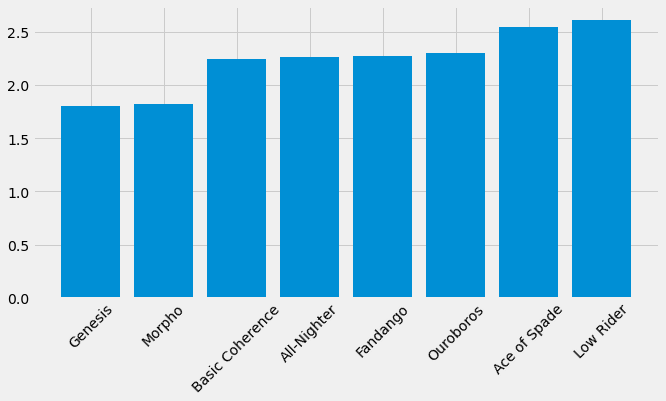

In [105]:
qual = tss_no_out.groupby('preset_label').mean(
)[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_2")

figure = plt.figure(figsize=(10, 5))
plt.bar(qual.index, qual["tss_qua_2"])
plt.xticks(rotation=45)

In [106]:
marg_means_df = params_df.loc[["Intercept", "Genesis", "Ouroboros", "Basic Coherence"],
                              ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac",
                               "tss_coh 90% CI margin", "tss_cre 90% CI margin",
                               "tss_avoid_rep 90% CI margin", "tss_pac 90% CI margin",
                               "tss_coh adj_p", "tss_cre adj_p",
                               "tss_avoid_rep adj_p", "tss_pac adj_p"]].copy()

for outcome in outcome_li:
    marg_means_df.loc[["Genesis", "Ouroboros", "Basic Coherence"], outcome] = marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence"], outcome].apply(
        lambda x: marg_means_df.loc["Intercept", outcome]+x)

marg_means_df.rename(index={"Intercept": "Grand Mean"}, inplace=True)
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_coh", "Coherence")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_cre", "Creativity")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_avoid_rep", "Avoiding Repitition")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_pac", "Pace")

In [107]:
marg_means_df

,Coherence,Creativity,Avoiding Repitition,Pace,Coherence 90% CI margin,Creativity 90% CI margin,Avoiding Repitition 90% CI margin,Pace 90% CI margin,Coherence adj_p,Creativity adj_p,Avoiding Repitition adj_p,Pace adj_p
Grand Mean,2.898807,2.562351,3.337513,3.287859,0.110538,0.131140,0.141642,0.141765,NaN,NaN,NaN,NaN
Genesis,2.525567,2.395988,3.511232,3.295745,0.171097,0.237207,0.232381,0.235561,0.002664,0.818458,0.408041,0.956089
Ouroboros,2.835690,2.620395,3.548051,3.114827,0.199918,0.235518,0.277292,0.274201,0.965678,0.913601,0.408041,0.598567
Basic Coherence,2.920725,2.560375,3.509965,3.387211,0.187579,0.257482,0.249210,0.267846,0.978675,0.989927,0.408041,0.866852


In [119]:
# Update GSheet from Basileus
gc = gs.oauth()

gsheet = gc.open("Preset Analysis").worksheet("Data")
gsheet_df = gd.get_as_dataframe(gsheet, index_col = "Preset")
gsheet_df.head(3)

,Coherence,Creativity,Avoiding Repitition,Pace,Coherence 90% CI margin,Creativity 90% CI margin,Avoiding Repitition 90% CI margin,Pace 90% CI margin,Coherence adj_p,Creativity adj_p,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
Preset,,,,,,,,,,,,,,,,,,,,,
Grand Mean,2.876315,2.820594,3.414783,3.336251,0.126815,0.142120,0.160098,0.133607,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genesis,2.537066,2.951098,3.549496,3.451415,0.205633,0.257478,0.249780,0.223817,0.053239,0.88005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ouroboros,2.764556,2.887898,3.656533,3.307569,0.243647,0.302998,0.295174,0.249688,0.539723,0.88005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Basic Coherence,"=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ace of Spades,"=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
existing.update(marg_means_df)
gsheet_df.head(3)

,Coherence,Creativity,Avoiding Repitition,Pace,Coherence 90% CI margin,Creativity 90% CI margin,Avoiding Repitition 90% CI margin,Pace 90% CI margin,Coherence adj_p,Creativity adj_p,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
Preset,,,,,,,,,,,,,,,,,,,,,
Grand Mean,2.876315,2.820594,3.414783,3.336251,0.126815,0.142120,0.160098,0.133607,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genesis,2.537066,2.951098,3.549496,3.451415,0.205633,0.257478,0.249780,0.223817,0.053239,0.88005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ouroboros,2.764556,2.887898,3.656533,3.307569,0.243647,0.302998,0.295174,0.249688,0.539723,0.88005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Basic Coherence,"=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ace of Spades,"=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100","=RANDBETWEEN(100,400)/100",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
gd.set_with_dataframe(gsheet, gsheet_df, include_index = True)